## Jack's Car Rental

In [1]:
import time
from functools import wraps
from itertools import product

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import poisson

### 1. Initialization


In [2]:
"""
We can divide the whole process into three stages. Suppose we have s=[s1, s2]
cars at the begining.

In the first stage, we move the car from one location to another at night.
Then we have ss=[ss1, ss2]=[s1+pi(s), s2-pi(s)] cars.

In the second stage, we rent out the car. Record the number of guests as a=[a1, a2] 
and we finally have ss-a=[ss1-a1, ss2-a2] cars.

In the final stage, we count the returned cars b=[b1, b2] into the total number of 
cars and we have s_=[s1_, s2_]=[ss1-a1+b1, ss2-a2+b2] cars.

Notation:
    s: number of cars in the beginning; 
    pi: policy;
    ss: number of cars after the first stage;
    s_: number of cars at the end;
    a: number of cars rented out;
    b: number of cars returned;
"""

# parameters
EvalEps = 1e-4  # threshold that determines whether the policy evaluation should terminate
Gamma = 0.9  # discount factor
Mu = [2, 3, 4]  # lambda of poisson distribution
NumberStates = 21  # number of statuses of one location
MaxMoving = 5  # maximum number of cars can be moved from one location to the other in one night


class Timer():
    def __init__(self) -> None:
        self.time = 0

    def timing(self, func):
        """
        Calculate the running time of the function.
        """
        @wraps(func)
        def wrapTheFunction(*args, **kwargs):
            start = time.time()

            func(*args, **kwargs)

            end = time.time()

            self.time += end - start
            print("Running Time of Function `{}`: {:.2f}s.".format(func.__name__, end - start))

        return wrapTheFunction

timer = Timer()

### 2. Poisson distribution

In [3]:
@timer.timing
def init_poisson_prob(poisson_prob):
    """
    Calculate the poisson probability in advance to prevent 
    double counting and save time.
    """
    for i, m in enumerate(Mu):
        for n in range(NumberStates):
            # We need two probabilities, one is Probability Mass Function
            # and the other is Survival Function.
            poisson_prob[i, n, 0] = poisson.pmf(n, m)
            poisson_prob[i, n, 1] = poisson.sf(n - 1, m)
    return


PoissonProb = np.zeros([len(Mu), NumberStates, 2])
init_poisson_prob(PoissonProb)

Running Time of Function `init_poisson_prob`: 0.02s.


### 3. Rental Reward and Probability Distributions

In [4]:
def _calc_reward_and_prob(ss1, ss2):
    """
    Traverse all possible values of the number of rental cars and the number of 
    returned cars to get the corresponding probability and reward. Then we sum
    them up to get the expected value of rental reward and probability 
    distributions of s_.
    """

    # The number of rental cars is limited by the number of cars in each location
    for a1, a2 in product(list(range(ss1+1)), list(range(ss2+1))):
        r = 10 * (a1 + a2)
        prob_a1 = PoissonProb[1, a1, int(a1 == ss1)]
        prob_a2 = PoissonProb[2, a2, int(a2 == ss2)]
        prob_a = prob_a1 * prob_a2

        # Caculate the expected value of rental reward
        RewardRent[ss1, ss2] += r * prob_a

        # The number of returned cars is limited by the maximum number of cars 
        # in each location
        b1_bound, b2_bound = NumberStates + a1 - ss1, NumberStates + a2 - ss2
        for b1, b2 in product(list(range(b1_bound)), list(range(b2_bound))):
            prob_b1 = PoissonProb[1, b1, int(b1 == b1_bound-1)]
            prob_b2 = PoissonProb[0, b2, int(b2 == b2_bound-1)]

            # Caculate probability distributions of s_
            s1_ = ss1 - a1 + b1
            s2_ = ss2 - a2 + b2
            Prob[s1_, s2_, ss1, ss2] += prob_a * prob_b1 * prob_b2
    return
        

@timer.timing
def calc_reward_and_prob():
    """
    Since the rental reward and distributions of s_ are independent of the initial state s
    when giving the number of cars after the first stage ss, we just need to calculate 
    rental reward and distributions of s_ for each state ss.
    For each state, we calculate them in advance to prevent double counting and save time.
    """
    for ss1, ss2 in product(list(range(NumberStates)), list(range(NumberStates))):
        _calc_reward_and_prob(ss1, ss2)
    return


# Both of reward_rent and prob are conditioned on the number of cars at the 
# beginning of the second stage, that is, ss.
# [ss_1, ss_2]
RewardRent = np.zeros([NumberStates, NumberStates])
# [s'_1, s'_2, ss_1, ss_2]
Prob = np.zeros([NumberStates, NumberStates, NumberStates, NumberStates])

# Calculate the expected value of rental reward and probability distributions of s_.
calc_reward_and_prob()

Running Time of Function `calc_reward_and_prob`: 11.22s.


### 4. Policy Iteration

In [5]:
def get_value(s1, s2, a):
    """
    In a given state and action, calculate Value.
    """
    ss1, ss2 = min(NumberStates-1, int(s1 + a)), min(NumberStates-1, int(s2 - a))
    v = RewardRent[ss1, ss2] + Gamma * (value * Prob[:, :, ss1, ss2]).sum() - 2 * abs(a)
    return v


def policy_eval():
    delta = float('inf')
    while delta > EvalEps:
        delta = 0
        for s1, s2 in product(list(range(NumberStates)), list(range(NumberStates))):
            v = value[s1, s2]
            
            # Update value
            a = policy[s1, s2]
            v_ = get_value(s1, s2, a)
            value[s1, s2] = v_

            delta = max(delta, abs(v - v_))
    return


def policy_improve():
    policy_stable = True
    for s1, s2 in product(list(range(NumberStates)), list(range(NumberStates))):
        a = policy[s1, s2]

        # Update policy
        # Action is limited by the number of cars available.
        actions_valid = [a for a in range(max(-s1, -MaxMoving), min(s2, MaxMoving) + 1)]
        values_valid = [get_value(s1, s2, a) for a in actions_valid]
        a_ = actions_valid[np.argmax(values_valid)]
        policy[s1, s2] = a_

        if a != a_:
            policy_stable = False
    return policy_stable


@timer.timing
def policy_iter():
    """
    Policy iteration algorithm.
    """
    policy_stable = False
    while not policy_stable:
        policy_eval()
        policy_stable = policy_improve()
    return

In [6]:
# Initialization
value = np.zeros([NumberStates, NumberStates])
# Number of cars moved from location2 to location1
policy = np.zeros([NumberStates, NumberStates])

# run
policy_iter()

Running Time of Function `policy_iter`: 1.02s.


In [7]:
print("Total Running Time: {:.2f}s.".format(timer.time))

Total Running Time: 12.25s.


### 5. Draw Results

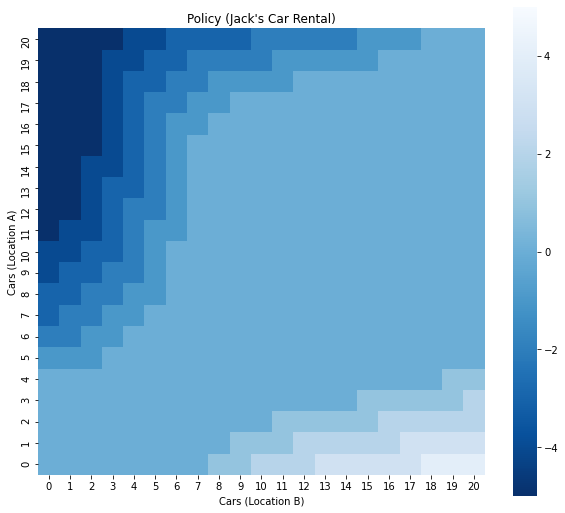

In [8]:
# Policy
df_policy = pd.DataFrame(
    policy[::-1],
    index=list(range(NumberStates-1, -1, -1)),
    columns=list(range(NumberStates)),
)

plt.figure(figsize=(10, 9))
sns.heatmap(data=df_policy, vmin=-5, vmax=5, square=True, cmap="Blues_r")
plt.title('Policy (Jack\'s Car Rental)')
plt.xlabel('Cars (Location B)')
plt.ylabel('Cars (Location A)')
plt.savefig("./fig/policy.png")

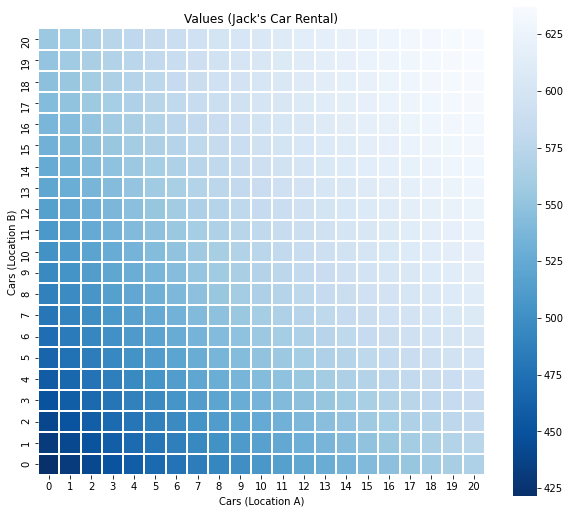

In [9]:
# Values
df_value = pd.DataFrame(
    value[::-1],
    index=list(range(NumberStates-1, -1, -1)),
    columns=list(range(NumberStates)),
)

plt.figure(figsize=(10, 9))
sns.heatmap(data=df_value, square=True, cmap="Blues_r", linewidths=0.1)
plt.title('Values (Jack\'s Car Rental)')
plt.xlabel('Cars (Location A)')
plt.ylabel('Cars (Location B)')
plt.savefig("./fig/value.png")